# Polars groupby on parquet data 2021+, eager vs lazy

In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

%load_ext autoreload
%autoreload 2

import datetime, os
display(f"Pandas {pd.__version__}, Polars {pl.__version__}")
display(f'Running: {datetime.datetime.now().strftime("%Y%m%d %H:%M:%S")}, env {os.getenv("CONDA_DEFAULT_ENV")}')

%load_ext ipython_memory_usage
%imu_start


def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = "Unknown"
    try:
        num_bytes = df.estimated_size()  # try Polars
        df_type = "Polars"
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum()  # try Pandas
        df_type = "Pandas"
    except AttributeError:
        pass
    display(
        f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes"
    )

'Pandas 2.1.3, Polars 0.19.17'

'Running: 20231203 10:29:04, env pydataglobal2023'

Enabling IPython Memory Usage, use %imu_start to begin, %imu_stop to end
In [1] used 0.4 MiB RAM in 0.19s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 210.8 MiB


In [2]:
dfple = pl.read_parquet("../test_result_2021on.parquet")

In [2] used 22446.8 MiB RAM in 4.83s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 22657.6 MiB


Notes from Ritchie via: https://pola-rs.github.io/polars-book/user-guide/lazy/query_plan/ via https://en.wikipedia.org/wiki/Relational_algebra

```
Pi 2/14 means we only select 2/14 columns.

Pi is relational algebra for projection (column selection)

Sigma is relational algebra for selection (row filtering)
```

In [3]:
show_rows_memory(dfple)

'Polars df with 82,012,245 rows, 11.17 GB bytes'

In [3] used 0.1 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 22657.7 MiB


In [4]:
dfple.lazy().groupby(by="make").agg("cylinder_capacity")

/tmp/ipykernel_50110/1666585407.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  dfple.lazy().groupby(by="make").agg("cylinder_capacity")


<LazyFrame [2 cols, {"make": Utf8, "cylinder_capacity": List(Int64)}] at 0x7F18F56AD690>

In [4] used 1.4 MiB RAM in 0.13s (system mean cpu 25%, single max cpu 85%), peaked 0.0 MiB above final usage, current RAM usage now 22659.1 MiB


/tmp/ipykernel_50110/2654239312.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  dfple.lazy().groupby(by="make").agg("cylinder_capacity").show_graph()


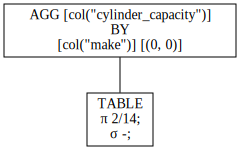

In [5] used 0.6 MiB RAM in 0.12s (system mean cpu 7%, single max cpu 70%), peaked 0.0 MiB above final usage, current RAM usage now 22659.7 MiB


In [5]:
dfple.lazy().groupby(by="make").agg("cylinder_capacity").show_graph()

In [6]:
print(dfple.lazy().groupby(by="make").agg("cylinder_capacity").explain(optimized=False))

AGGREGATE
	[col("cylinder_capacity")] BY [col("make")] FROM
  DF ["test_id", "vehicle_id", "test_date", "test_class_id"]; PROJECT */14 COLUMNS; SELECTION: "None"


/tmp/ipykernel_50110/4214920071.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  print(dfple.lazy().groupby(by="make").agg("cylinder_capacity").explain(optimized=False))


In [6] used 0.1 MiB RAM in 0.10s (system mean cpu 12%, single max cpu 64%), peaked 0.0 MiB above final usage, current RAM usage now 22659.8 MiB


In [7]:
dfple.lazy().groupby(by="make").agg("cylinder_capacity").profile()

/tmp/ipykernel_50110/959021242.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  dfple.lazy().groupby(by="make").agg("cylinder_capacity").profile()


(shape: (12_290, 2)
 ┌────────────────────────┬──────────────────────┐
 │ make                   ┆ cylinder_capacity    │
 │ ---                    ┆ ---                  │
 │ str                    ┆ list[i64]            │
 ╞════════════════════════╪══════════════════════╡
 │ DENNIS PLAXTON         ┆ [5500, 5500]         │
 │ LANCER EVO V1          ┆ [2000]               │
 │ AUDI A4 AVANT TDI 2.0L ┆ [1968]               │
 │ HARLEY- DAVIDSON       ┆ [1580, 1580]         │
 │ …                      ┆ …                    │
 │ JG FALCON              ┆ [1800]               │
 │ BD                     ┆ [null, null]         │
 │ TOMCAT                 ┆ [3948]               │
 │ BURSTNER IXEO 590      ┆ [2287, 2287, … 2287] │
 └────────────────────────┴──────────────────────┘,
 shape: (2, 3)
 ┌────────────────┬───────┬─────────┐
 │ node           ┆ start ┆ end     │
 │ ---            ┆ ---   ┆ ---     │
 │ str            ┆ u64   ┆ u64     │
 ╞════════════════╪═══════╪═════════╡
 │ optimi

In [7] used 747.5 MiB RAM in 3.16s (system mean cpu 56%, single max cpu 100%), peaked 1527.8 MiB above final usage, current RAM usage now 23407.3 MiB


In [8]:
%%time
result = (
    dfple.filter(pl.col("cylinder_capacity").is_not_null())
    .group_by(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
)
result[:3]

CPU times: user 32.1 s, sys: 9.53 s, total: 41.6 s
Wall time: 4.37 s


make,median,count
str,f64,u32
"""TESLA""",0.0,16
"""VECTRIX""",4.0,13
"""RALEIGH""",49.0,41


In [8] used -59.8 MiB RAM in 4.48s (system mean cpu 74%, single max cpu 100%), peaked 12894.7 MiB above final usage, current RAM usage now 23347.6 MiB


In [9]:
# note collect(streaming=True) same result

In [9] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 23347.6 MiB


In [10]:
%%time
result = (
    dfple.lazy()
    .filter(pl.col("cylinder_capacity").is_not_null())
    .group_by(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
    .collect()
)

CPU times: user 25.3 s, sys: 2.69 s, total: 28 s
Wall time: 3.48 s
In [10] used -87.6 MiB RAM in 3.58s (system mean cpu 65%, single max cpu 100%), peaked 4002.0 MiB above final usage, current RAM usage now 23259.9 MiB


In [11]:
result[:3]

make,median,count
str,f64,u32
"""TESLA""",0.0,16
"""VECTRIX""",4.0,13
"""LINTEX HT50QT-…",49.0,15


In [11] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 23259.9 MiB


In [12]:
result.filter(pl.col("make") == "ROLLS ROYCE")

make,median,count
str,f64,u32
"""ROLLS ROYCE""",6749.0,11741


In [12] used 0.2 MiB RAM in 0.10s (system mean cpu 9%, single max cpu 46%), peaked 0.0 MiB above final usage, current RAM usage now 23260.2 MiB


In [13]:
assert result.filter(pl.col("make") == "ROLLS ROYCE")["median"].item() == 6749.0
assert result.filter(pl.col("make") == "ROLLS ROYCE")["count"].item() == 11741.0

In [13] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 23260.2 MiB


/tmp/ipykernel_50110/4040521520.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(


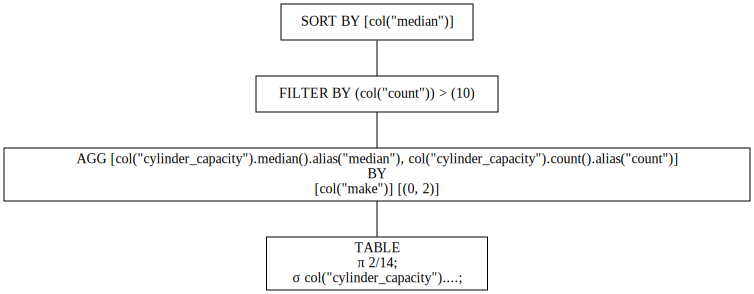

In [14] used 0.0 MiB RAM in 0.12s (system mean cpu 17%, single max cpu 62%), peaked 0.0 MiB above final usage, current RAM usage now 23260.2 MiB


In [14]:
# figsize in show_graph
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").show_graph()

In [15]:
print(
    dfple.lazy()
    .filter(pl.col("cylinder_capacity").is_not_null())
    .groupby(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
    .explain(optimized=False)
)

SORT BY [col("median")]
  FILTER [(col("count")) > (10)] FROM

  AGGREGATE
  	[col("cylinder_capacity").median().alias("median"), col("cylinder_capacity").count().alias("count")] BY [col("make")] FROM
    FILTER col("cylinder_capacity").is_not_null() FROM

    DF ["test_id", "vehicle_id", "test_date", "test_class_id"]; PROJECT */14 COLUMNS; SELECTION: "None"


/tmp/ipykernel_50110/2777726555.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(by="make")


In [15] used 0.0 MiB RAM in 0.10s (system mean cpu 9%, single max cpu 46%), peaked 0.0 MiB above final usage, current RAM usage now 23260.2 MiB


In [16]:
print(
    dfple.lazy()
    .filter(pl.col("cylinder_capacity").is_not_null())
    .groupby(by="make")
    .agg(
        [
            pl.col("cylinder_capacity").median().alias("median"),
            pl.col("cylinder_capacity").count().alias("count"),
        ]
    )
    .filter(pl.col("count") > 10)
    .sort(by="median")
    .explain()
)

SORT BY [col("median")]
  FILTER [(col("count")) > (10)] FROM

  AGGREGATE
  	[col("cylinder_capacity").median().alias("median"), col("cylinder_capacity").count().alias("count")] BY [col("make")] FROM
    DF ["test_id", "vehicle_id", "test_date", "test_class_id"]; PROJECT 2/14 COLUMNS; SELECTION: "col(\"cylinder_capacity\").is_not_null()"


/tmp/ipykernel_50110/2991613191.py:4: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  .groupby(by="make")


In [16] used 0.0 MiB RAM in 0.10s (system mean cpu 10%, single max cpu 73%), peaked 0.0 MiB above final usage, current RAM usage now 23260.2 MiB


In [17]:
# .profile() only exists for Lazy dataframe
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").profile()

/tmp/ipykernel_50110/2851134922.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(


(shape: (1_275, 3)
 ┌──────────────────┬─────────┬───────┐
 │ make             ┆ median  ┆ count │
 │ ---              ┆ ---     ┆ ---   │
 │ str              ┆ f64     ┆ u32   │
 ╞══════════════════╪═════════╪═══════╡
 │ TESLA            ┆ 0.0     ┆ 16    │
 │ VECTRIX          ┆ 4.0     ┆ 13    │
 │ SONIK            ┆ 49.0    ┆ 35    │
 │ YAMASAKI YM50-RE ┆ 49.0    ┆ 22    │
 │ …                ┆ …       ┆ …     │
 │ LEYLAND NATIONAL ┆ 10450.0 ┆ 15    │
 │ NEOPLAN          ┆ 12609.5 ┆ 18    │
 │ KENWORTH         ┆ 14000.0 ┆ 11    │
 │ SETRA            ┆ 14618.0 ┆ 19    │
 └──────────────────┴─────────┴───────┘,
 shape: (4, 3)
 ┌──────────────────────────────────┬─────────┬─────────┐
 │ node                             ┆ start   ┆ end     │
 │ ---                              ┆ ---     ┆ ---     │
 │ str                              ┆ u64     ┆ u64     │
 ╞══════════════════════════════════╪═════════╪═════════╡
 │ optimization                     ┆ 0       ┆ 974715  │
 │ group_by(make)

In [17] used -85.3 MiB RAM in 3.36s (system mean cpu 63%, single max cpu 100%), peaked 4029.0 MiB above final usage, current RAM usage now 23174.9 MiB


/tmp/ipykernel_50110/3924508235.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
/tmp/ipykernel_50110/3924508235.py:7: DeprecationWarning: `the argument common_subplan_elimination` for `profile` is deprecated. It has been renamed to `comm_subplan_elim`.
  ).filter(pl.col("count") > 10).sort(by="median").profile(


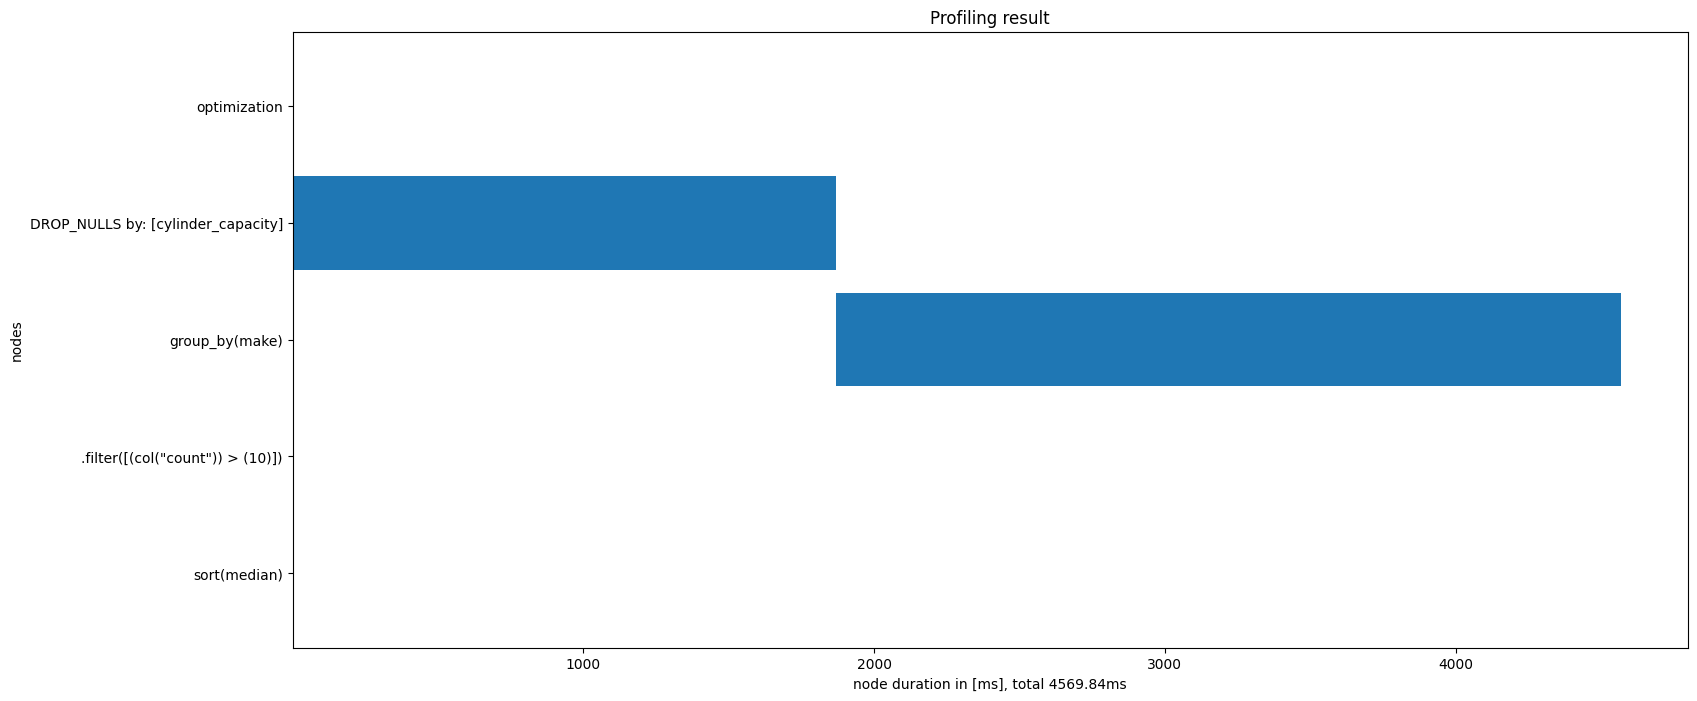

(shape: (1_275, 3)
 ┌──────────────────┬─────────┬───────┐
 │ make             ┆ median  ┆ count │
 │ ---              ┆ ---     ┆ ---   │
 │ str              ┆ f64     ┆ u32   │
 ╞══════════════════╪═════════╪═══════╡
 │ TESLA            ┆ 0.0     ┆ 16    │
 │ VECTRIX          ┆ 4.0     ┆ 13    │
 │ LEEWAY C8        ┆ 49.0    ┆ 14    │
 │ SIMSON           ┆ 49.0    ┆ 26    │
 │ …                ┆ …       ┆ …     │
 │ LEYLAND NATIONAL ┆ 10450.0 ┆ 15    │
 │ NEOPLAN          ┆ 12609.5 ┆ 18    │
 │ KENWORTH         ┆ 14000.0 ┆ 11    │
 │ SETRA            ┆ 14618.0 ┆ 19    │
 └──────────────────┴─────────┴───────┘,
 shape: (5, 3)
 ┌───────────────────────────────────┬─────────┬─────────┐
 │ node                              ┆ start   ┆ end     │
 │ ---                               ┆ ---     ┆ ---     │
 │ str                               ┆ u64     ┆ u64     │
 ╞═══════════════════════════════════╪═════════╪═════════╡
 │ optimization                      ┆ 0       ┆ 4       │
 │ DROP_NUL

In [18] used -75.5 MiB RAM in 4.80s (system mean cpu 67%, single max cpu 100%), peaked 12913.7 MiB above final usage, current RAM usage now 23099.4 MiB


In [18]:
# .profile() only exists for Lazy dataframe
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").profile(
    type_coercion=False,
    predicate_pushdown=False,
    projection_pushdown=False,
    simplify_expression=False,
    slice_pushdown=False,
    common_subplan_elimination=False,
    show_plot=True,
)

/tmp/ipykernel_50110/2470338583.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(


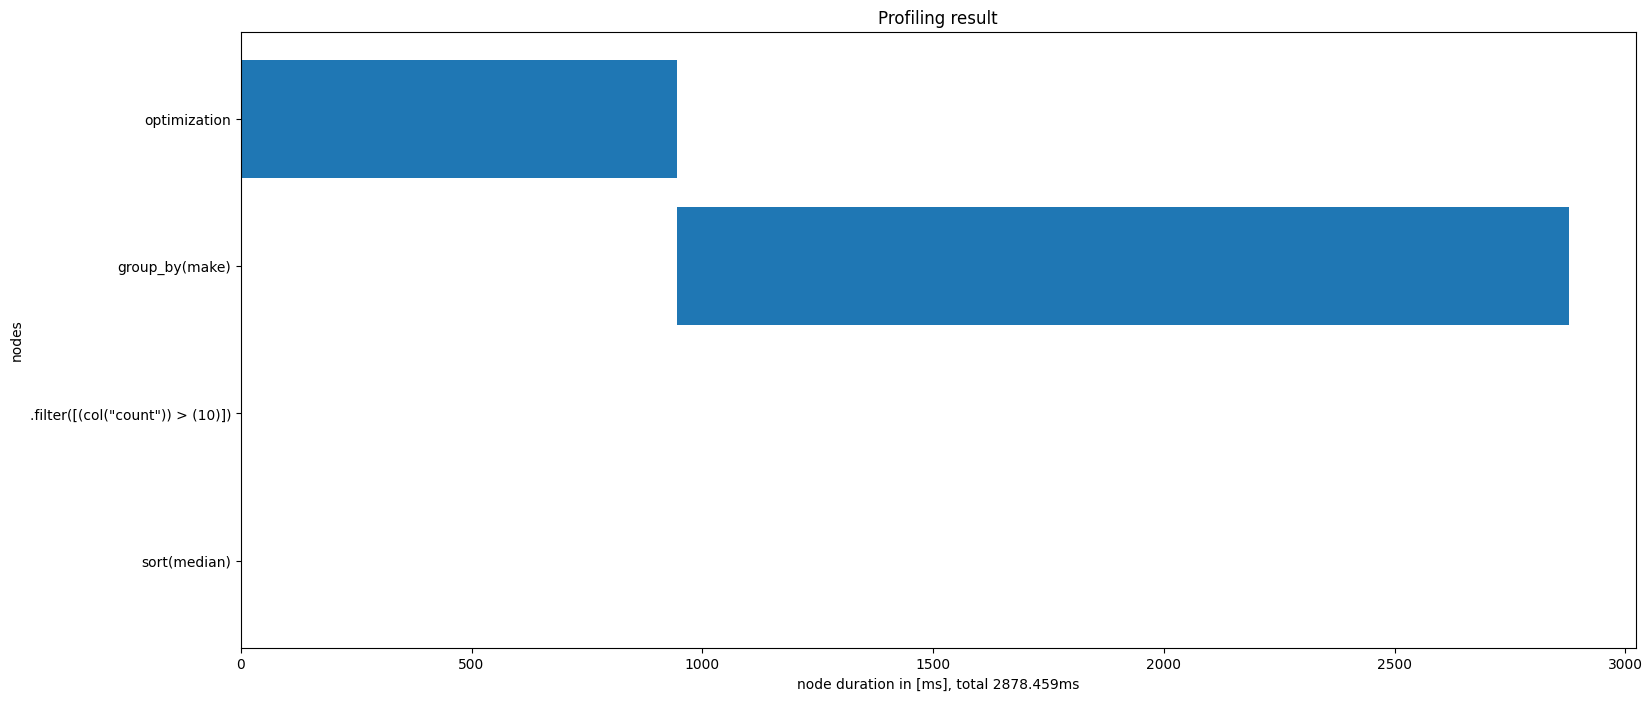

(shape: (1_275, 3)
 ┌─────────────────────┬─────────┬───────┐
 │ make                ┆ median  ┆ count │
 │ ---                 ┆ ---     ┆ ---   │
 │ str                 ┆ f64     ┆ u32   │
 ╞═════════════════════╪═════════╪═══════╡
 │ TESLA               ┆ 0.0     ┆ 16    │
 │ VECTRIX             ┆ 4.0     ┆ 13    │
 │ DIRECT BIKES DB50QT ┆ 49.0    ┆ 45    │
 │ LINTEX HT50QT-16    ┆ 49.0    ┆ 12    │
 │ …                   ┆ …       ┆ …     │
 │ LEYLAND NATIONAL    ┆ 10450.0 ┆ 15    │
 │ NEOPLAN             ┆ 12609.5 ┆ 18    │
 │ KENWORTH            ┆ 14000.0 ┆ 11    │
 │ SETRA               ┆ 14618.0 ┆ 19    │
 └─────────────────────┴─────────┴───────┘,
 shape: (4, 3)
 ┌──────────────────────────────────┬─────────┬─────────┐
 │ node                             ┆ start   ┆ end     │
 │ ---                              ┆ ---     ┆ ---     │
 │ str                              ┆ u64     ┆ u64     │
 ╞══════════════════════════════════╪═════════╪═════════╡
 │ optimization               

In [19] used 11.7 MiB RAM in 3.06s (system mean cpu 57%, single max cpu 100%), peaked 3971.3 MiB above final usage, current RAM usage now 23111.1 MiB


In [19]:
dfple.lazy().filter(pl.col("cylinder_capacity").is_not_null()).groupby(by="make").agg(
    [
        pl.col("cylinder_capacity").median().alias("median"),
        pl.col("cylinder_capacity").count().alias("count"),
    ]
).filter(pl.col("count") > 10).sort(by="median").profile(show_plot=True)

# Resample

In [20]:
dfple.head()

test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
i64,i64,datetime[μs],i64,str,str,i64,str,str,str,str,str,i64,datetime[μs]
334683447,634775234,2022-01-01 00:00:00,4,"""NT""","""P""",227219,"""E""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1497,2008-01-17 00:00:00
586095521,1220215709,2022-01-01 00:00:00,4,"""NT""","""P""",136552,"""CR""","""TOYOTA""","""PRIUS""","""GREY""","""Hybrid Electri…",1798,2013-11-29 00:00:00
960974211,1315791989,2022-01-01 00:00:00,4,"""NT""","""F""",129847,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00
1041792341,1144451355,2022-01-01 00:00:00,4,"""NT""","""P""",123133,"""TW""","""TOYOTA""","""PRIUS""","""SILVER""","""Hybrid Electri…",1496,2016-11-21 00:00:00
1587264975,1315791989,2022-01-01 00:00:00,4,"""RT""","""P""",129848,"""E""","""TOYOTA""","""PRIUS""","""WHITE""","""Hybrid Electri…",1798,2018-01-01 00:00:00


In [20] used -0.6 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 23110.5 MiB


In [21]:
#dfple = pl.read_parquet("../test_result_2021on.parquet")
# note sunday morning pretty sure i don't need to read this again, it dupes memory

In [21] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 23110.5 MiB


In [22]:
# dfple = dfple.with_columns(pl.col('test_date').dt.year().alias('test_year'))
#dfple = dfple.with_columns((pl.col("test_result") == pl.lit("P")).alias("passed"))
# dfple.sample(10000).with_columns((pl.col('cylinder_capacity')>1000).alias('other'))

In [22] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 23110.5 MiB


In [23]:
# dfple.head(10000).sort(pl.col('test_date')).groupby_dynamic('test_date', every='1w').agg(pl.col('test_type')).mean()

In [23] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 23110.5 MiB


In [24]:
dfple = dfple.with_columns((pl.col("test_result") == pl.lit("P")). \
                           alias("passed"))
result = (
    dfple.sort(pl.col("test_date"))
    .group_by_dynamic("test_date", every="1w")
    .agg(pl.col("passed").sum())
)

In [24] used 60.4 MiB RAM in 6.76s (system mean cpu 55%, single max cpu 100%), peaked 14214.5 MiB above final usage, current RAM usage now 23170.9 MiB


Text(2021-03-26 00:00:00, 200000, 'April Lockdown\neffect from 2020?')

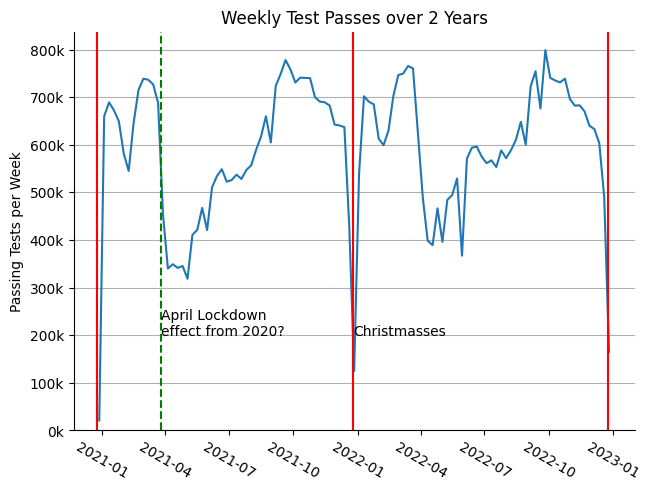

In [25] used 1.2 MiB RAM in 0.33s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 23172.1 MiB


In [25]:
from simpler_mpl import set_common_mpl_styles, set_commas

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(result["test_date"], result["passed"])  # , marker='o')
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(x/1000):,}k")
plt.xticks(rotation=-30)
set_common_mpl_styles(
    ax, title="Weekly Test Passes over 2 Years", ymin=0, ylabel="Passing Tests per Week"
)  # , xlabel="Weekly 2021-2022")
ax.axvline(pd.to_datetime("2020-12-25"), color="red")
ax.axvline(pd.to_datetime("2021-12-25"), color="red")
ax.annotate("Christmasses", (pd.to_datetime("2021-12-25"), 200000))
ax.axvline(pd.to_datetime("2022-12-25"), color="red")
# ax.annotate('Christmas', (pd.to_datetime('2022-09-10'), 200000)) # horrid offset for alignment
ax.axvline(pd.to_datetime("2021-03-26"), color="green", linestyle="--")
ax.annotate("April Lockdown\neffect from 2020?", (pd.to_datetime("2021-03-26"), 200000))

## Resample but on larger dataset

In [26]:
dfpll = pl.scan_parquet("../test_result.parquet/*.parquet")
dfpll.select(pl.count()).collect().item()

639506968

In [26] used 746.8 MiB RAM in 4.13s (system mean cpu 39%, single max cpu 100%), peaked 8777.8 MiB above final usage, current RAM usage now 23919.0 MiB


In [27]:
import datetime

# 82012876
dfpll.filter(pl.col("test_date") > datetime.datetime(2021, 1, 1)).select(
    pl.count()
).collect()

count
u32
82012245


In [27] used 80.1 MiB RAM in 2.81s (system mean cpu 70%, single max cpu 100%), peaked 1757.4 MiB above final usage, current RAM usage now 23999.1 MiB


In [28]:
result_lz = (
    dfpll.filter(pl.col("test_date") > datetime.datetime(2018, 1, 1))
    .with_columns((pl.col("test_result") == pl.lit("P")).alias("passed"))
    .sort(pl.col("test_date"))
    .group_by_dynamic("test_date", every="1w")
    .agg(pl.col("passed").sum())
    .collect()
)

In [28] used -111.6 MiB RAM in 13.05s (system mean cpu 39%, single max cpu 100%), peaked 9376.1 MiB above final usage, current RAM usage now 23887.4 MiB


Text(2020-04-01 00:00:00, 100000, 'Lockdown\nknock-on')

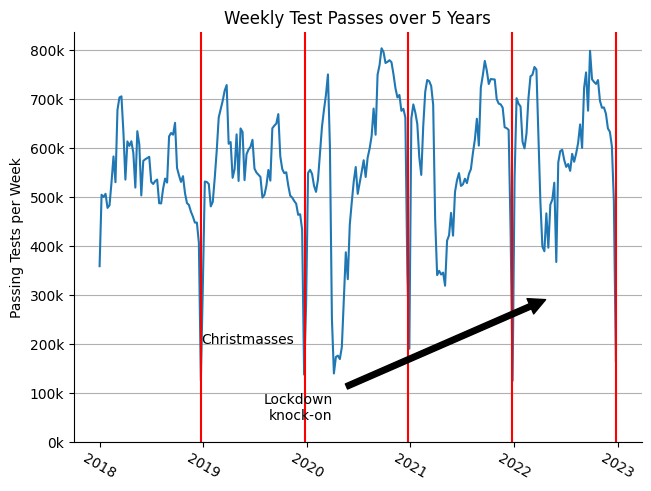

In [29] used 0.9 MiB RAM in 0.39s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 23888.3 MiB


In [29]:
from simpler_mpl import set_common_mpl_styles, set_commas

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(result_lz["test_date"], result_lz["passed"])  # , marker='o')
ax.yaxis.set_major_formatter(lambda x, pos: f"{int(x/1000):,}k")
plt.xticks(rotation=-30)
set_common_mpl_styles(
    ax, title="Weekly Test Passes over 5 Years", ymin=0, ylabel="Passing Tests per Week"
)  # , xlabel="Weekly 2021-2022")
for dt_str in ["2018-12-25", "2019-12-25", "2020-12-25", "2021-12-25", "2022-12-25"]:
    ax.axvline(pd.to_datetime(dt_str), color="red")
ax.annotate(
    "Christmasses", (pd.to_datetime("2018-12-25"), 200000)
)  # horrid offset for alignment
ax.annotate(
    "Lockdown\nknock-on",
    (pd.to_datetime("2022-06"), 300000),
    # textcoords='axes fraction',
    xytext=(pd.to_datetime("2020-04"), 100000),
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="right",
    verticalalignment="top",
)